In [1]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


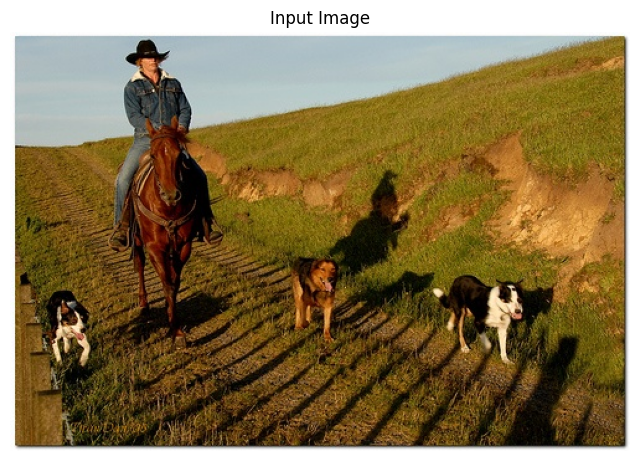

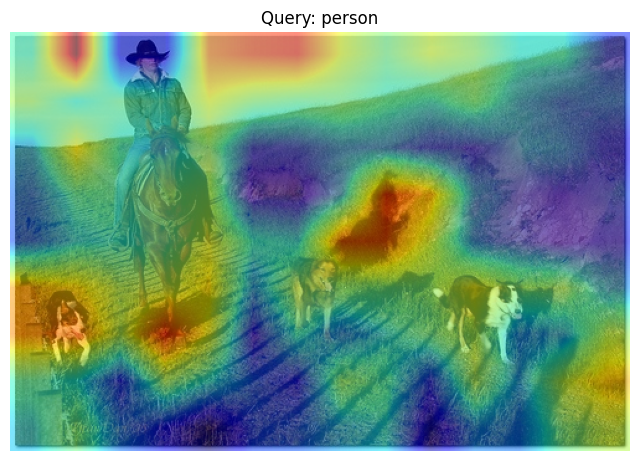

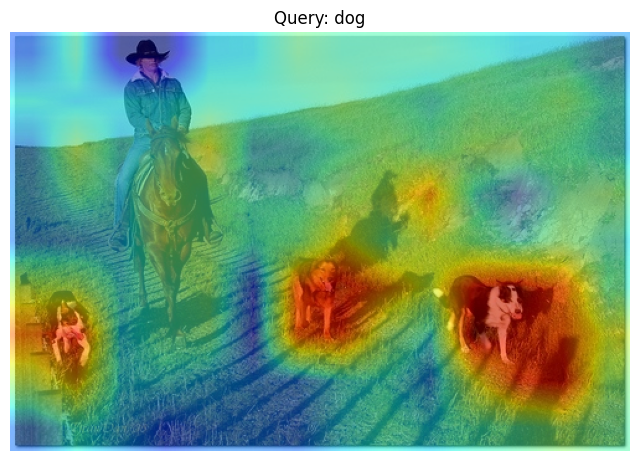

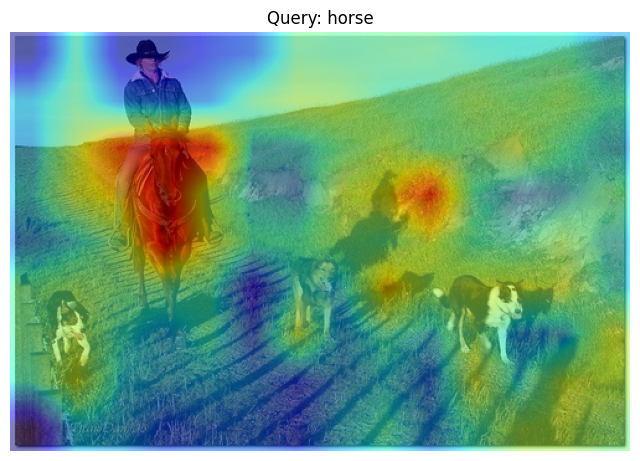

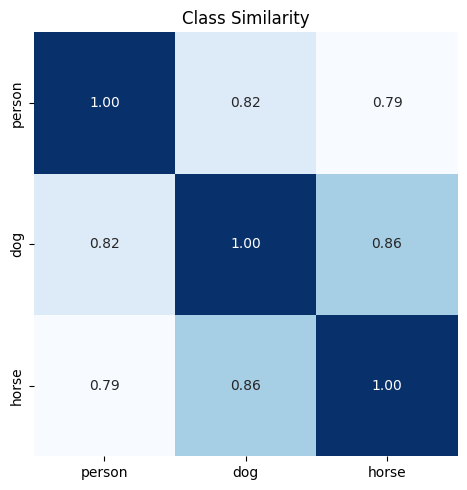

In [2]:
from utils.encoders import load_clip, encode_text
from utils.similarity import generate_similarity_map
from utils.viz import show_image, show_similarity_overlay, show_similarity_matrix
from PIL import Image

model, preprocess = load_clip(backbone="RN101", device=device)
image = Image.open("../datasets/VOCdevkit/VOC2007/JPEGImages/008509.jpg").convert("RGB")
texts = ["person", "dog", "horse"]
text_features = encode_text(model, texts, device)

show_image(image, "Input Image")

sim_maps = generate_similarity_map(model, preprocess, image, text_features, patch_size=64, stride=32, device=device)
for i, sim_map in enumerate(sim_maps):
    show_similarity_overlay(image, sim_map, texts[i])

show_similarity_matrix(texts=texts, text_features=text_features)
